<h1>Model comparison</h1>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

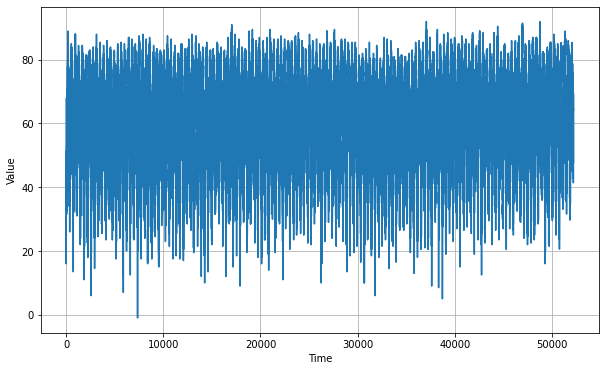

In [4]:
import csv
time_step = []
temps = []

###with open('/content/drive/MyDrive/Birmingham-mean.csv') as csvfile:
with open('Birmingham-mean.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 40000
time_train = time[:split_time] 
x_train = series[:split_time] 
time_valid = time[split_time:] 
x_valid = series[split_time:]

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(40000,)


<h2>1. CNN</h2>

In [9]:
model_CNN = tf.keras.models.load_model('CNN_model.h5')

In [10]:
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         512       
_________________________________________________________________
dense (Dense)                (None, None, 28)          3612      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          290       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
Total params: 4,425
Trainable params: 4,425
Non-trainable params: 0
_________________________________________________________________


In [111]:
forecast = model_forecast(model_CNN, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

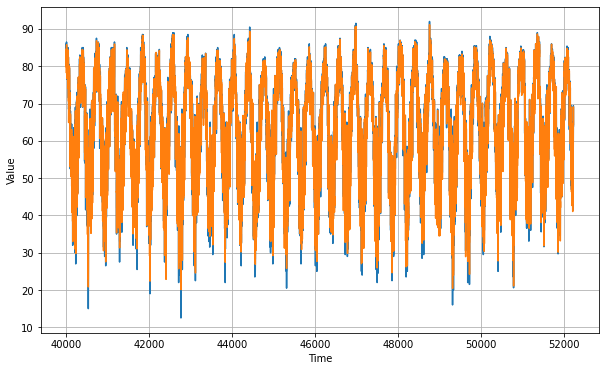

In [12]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [112]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.4801507

In [113]:
mae_CNN = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

<h2>2. Simple RNN</h2>

In [15]:
model_RNN = tf.keras.models.load_model('RNN_model.h5')

In [16]:
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 100)         10200     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 100)         20100     
_________________________________________________________________
dense (Dense)                (None, None, 1)           101       
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [17]:
forecast = model_forecast(model_RNN, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

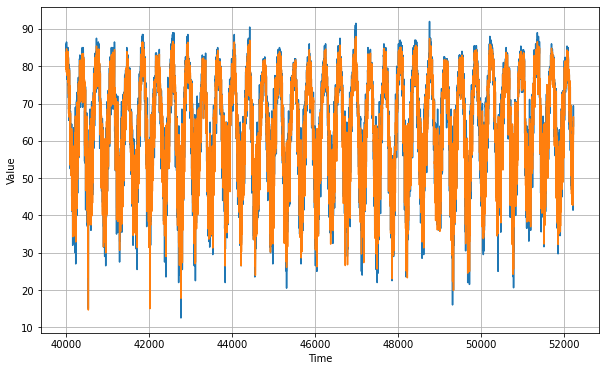

In [18]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.5306163

In [20]:
mae_RNN = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

<h2>3. GRU</h2>

In [21]:
model_GRU = tf.keras.models.load_model('GRU_model.h5')

In [22]:
model_GRU.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 100)         30900     
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 91,601
Trainable params: 91,601
Non-trainable params: 0
_________________________________________________________________


In [77]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [24]:
forecast = model_forecast(model_GRU, series[split_time - window_size: -1], window_size)[:,0]

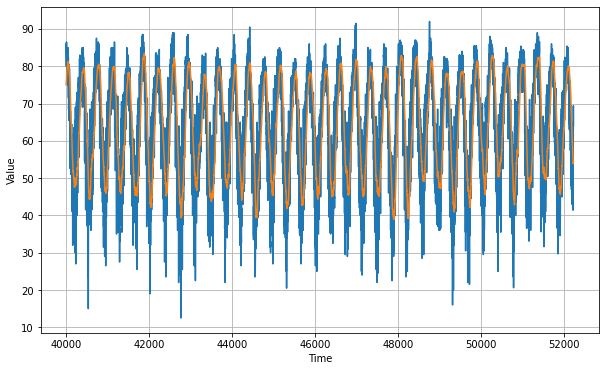

In [25]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

7.7253323

In [27]:
mae_GRU = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

<h2>4. LSTM</h2>

In [28]:
model_LSTM = tf.keras.models.load_model('LSTM_model.h5')

In [29]:
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 64)          16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [30]:
forecast = model_forecast(model_LSTM, series[split_time - window_size: -1], window_size)[:,0]

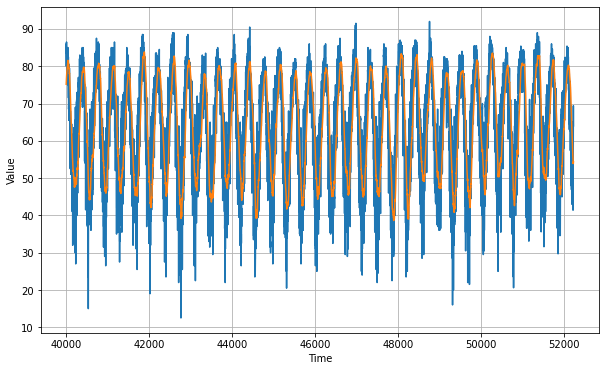

In [31]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [32]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

7.7593384

In [33]:
mae_LSTM = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

<h2>5. Bidirectional GRU</h2>

In [34]:
model_Bi_GRU = tf.keras.models.load_model('Bi_GRU_model.h5')

In [35]:
model_Bi_GRU.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 200)         61800     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               181200    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 243,201
Trainable params: 243,201
Non-trainable params: 0
_________________________________________________________________


In [36]:
forecast = model_forecast(model_Bi_GRU, series[split_time - window_size: -1], window_size)[:,0]

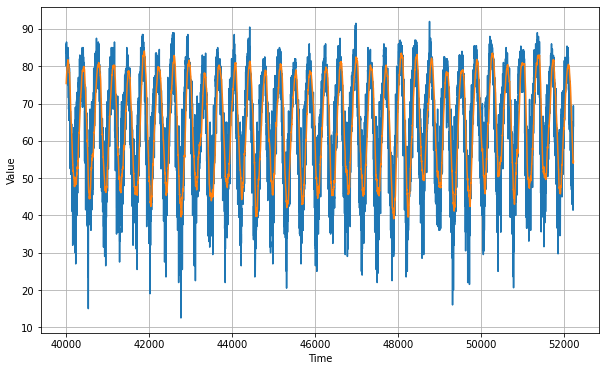

In [37]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [38]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

7.702015

In [39]:
mae_Bi_GRU = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

<h2>6. Bidirectional LSTM</h2>

In [40]:
model_Bi_LSTM = tf.keras.models.load_model('Bi_LSTM_model.h5')

In [41]:
model_Bi_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 128)         33792     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 132,737
Trainable params: 132,737
Non-trainable params: 0
_________________________________________________________________


In [42]:
forecast = model_forecast(model_Bi_LSTM, series[split_time - window_size: -1], window_size)[:,0]

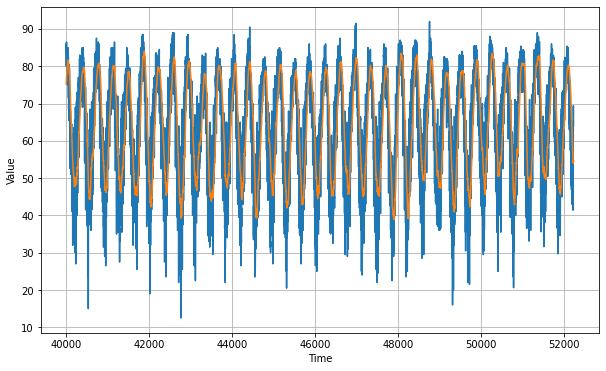

In [43]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [44]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

7.727791

In [45]:
mae_Bi_LSTM = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

<h2>7. CNN + LSTM</h2>

In [78]:
model_CNN_LSTM = tf.keras.models.load_model('CNN_LSTM_model.h5')

In [79]:
model_CNN_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense_3 (Dense)              (None, None, 30)          1950      
_________________________________________________________________
dense_4 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           11        
Total params: 60,319
Trainable params: 60,319
Non-trainable params: 0
__________________________________________________

In [80]:
#forecast = model_forecast(model_CNN_LSTM, series[split_time - window_size: -1], window_size)[:,0]

In [116]:
forecast = model_forecast(model_CNN_LSTM, series[..., np.newaxis], window_size)
forecast = forecast[split_time - window_size:-1, -1, 0]

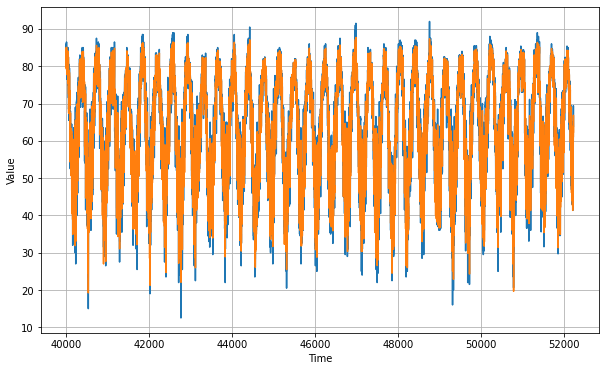

In [117]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [118]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

3.2931962

In [85]:
mae_CNN_LSTM = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

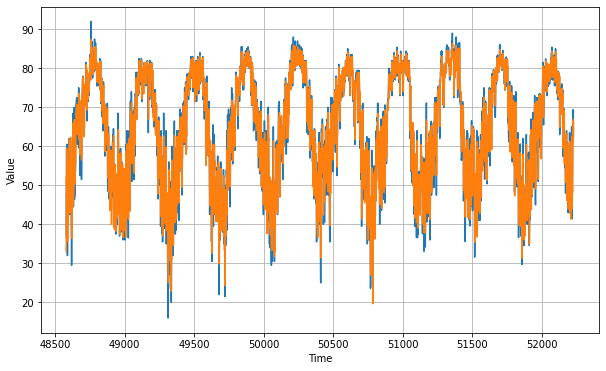

In [119]:
plt.figure(figsize=(10, 6))

time_valid5 = time_valid[8580:]
x_valid5 = x_valid[8580:]
results5 = forecast[8580:]
plot_series(time_valid5, x_valid5)
plot_series(time_valid5, results5)

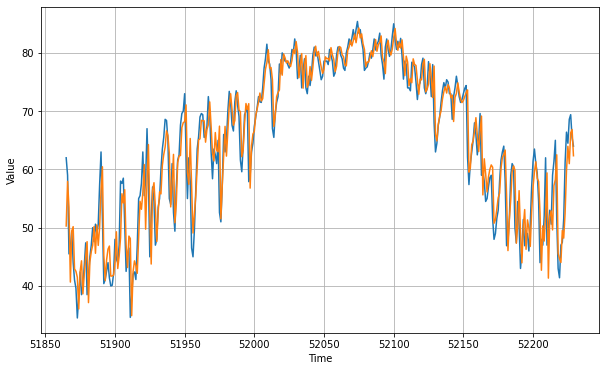

In [120]:
plt.figure(figsize=(10, 6))

time_valid6 = time_valid[11865:]
x_valid6 = x_valid[11865:]
results6 = forecast[11865:]
plot_series(time_valid6, x_valid6)
plot_series(time_valid6, results6)

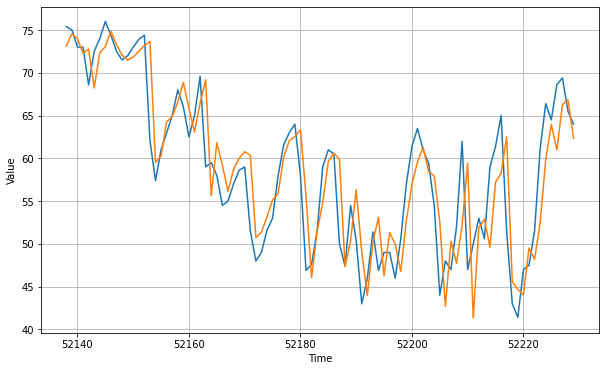

In [121]:
plt.figure(figsize=(10, 6))

time_valid7 = time_valid[12138:]
x_valid7 = x_valid[12138:]
results7 = forecast[12138:]
plot_series(time_valid7, x_valid7)
plot_series(time_valid7, results7)

<h2>8. CNN + Simple RNN</h2>

In [52]:
model_CNN_RNN = tf.keras.models.load_model('CNN_RNN_model.h5')

In [53]:
model_CNN_RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 100)         13300     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 100)         20100     
_________________________________________________________________
dense (Dense)                (None, None, 30)          3030      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
Total params: 36,943
Trainable params: 36,943
Non-trainable params: 0
____________________________________________________

In [86]:
forecast = model_forecast(model_CNN_RNN, series[..., np.newaxis], window_size)
forecast = forecast[split_time - window_size:-1, -1, 0]

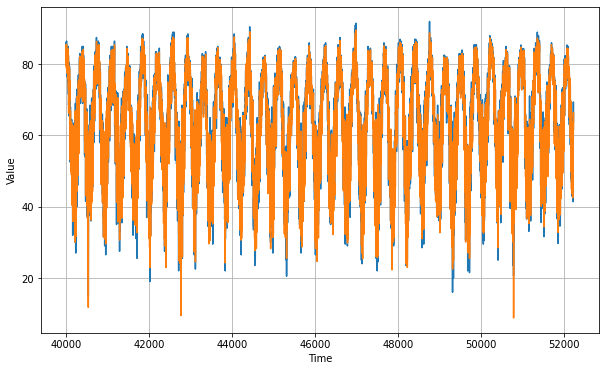

In [87]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [88]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

3.5161986

In [89]:
mae_CNN_RNN = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

<h2>9. Simple DNN</h2>

In [58]:
model_DNN = tf.keras.models.load_model('DNN_model.h5')

In [59]:
model_DNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, None, 20)          40        
_________________________________________________________________
dense_4 (Dense)              (None, None, 10)          210       
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           11        
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


In [90]:
forecast = model_forecast(model_DNN, series[..., np.newaxis], window_size)
forecast = forecast[split_time - window_size:-1, -1, 0]

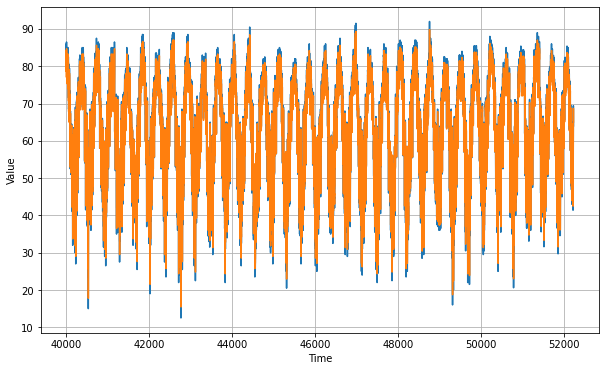

In [91]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [92]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

3.7161698

In [93]:
mae_DNN = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

<h2>10. CNN + GRU</h2>

In [100]:
model_CNN_GRU = tf.keras.models.load_model('CNN_GRU_model.h5')

In [101]:
model_CNN_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
gru (GRU)                    (None, None, 100)         40200     
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 104,343
Trainable params: 104,343
Non-trainable params: 0
________________________________________________

In [102]:
forecast = model_forecast(model_CNN_GRU, series[split_time - window_size: -1], window_size)[:,0]

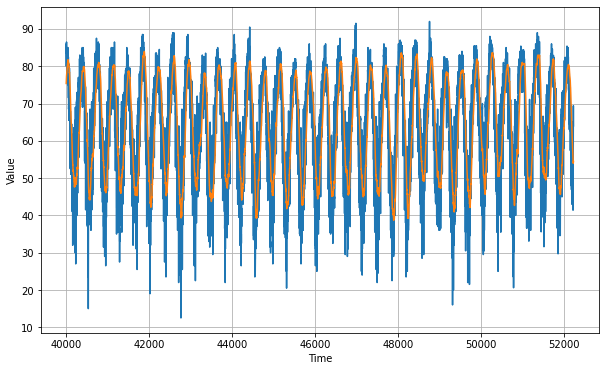

In [103]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [104]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

7.746203

In [105]:
mae_CNN_GRU = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

In [108]:
model = tf.keras.models.load_model('Bi_LSTM_model.h5')

In [109]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

In [110]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

7.727791

<h2>Table of MAE of models</h2>

In [114]:
models = ['Simple DNN', 'CNN', 'Simple RNN', 'GRU', 'Bidirectional GRU', 'LSTM', 'Bidirectional LSTM',
          'CNN + Simple RNN', 'CNN + GRU', 'CNN + LSTM']
mae = [mae_DNN, mae_CNN, mae_RNN, mae_GRU, mae_Bi_GRU, mae_LSTM, mae_Bi_LSTM, mae_CNN_RNN, mae_CNN_GRU, mae_CNN_LSTM]

In [97]:
import pandas as pd

In [115]:
df = pd.DataFrame(list(zip(models, mae)),
               columns =['Model', 'Mean Absolute Error'])
df

,Model,Mean Absolute Error
0,Simple DNN,3.716170
1,CNN,3.480151
2,Simple RNN,3.530616
3,GRU,7.725332
4,Bidirectional GRU,7.702015
5,LSTM,7.759338
6,Bidirectional LSTM,7.727791
7,CNN + Simple RNN,3.516199
8,CNN + GRU,7.746203
9,CNN + LSTM,3.293196


| Mean Absolute Error | Model              |
|---------------------|--------------------|
| 3.293196            | CNN + LSTM         |
| 3.480151            | CNN                |
| 3.516199            | CNN + Simple RNN   |
| 3.530616            | Simple RNN         |
| 3.716170            | Simple DNN         |
| 7.702015            | Bidirectional GRU  |
| 7.725332            | GRU                |
| 7.727791            | Bidirectional LSTM |
| 7.746203            | CNN + GRU          |
| 7.725332            | GRU                |